# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")

import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp
import utils.utils as ut
# import lc
import os
torch.set_default_dtype(torch.float64)



# Setting light curve

## importing fake light curve

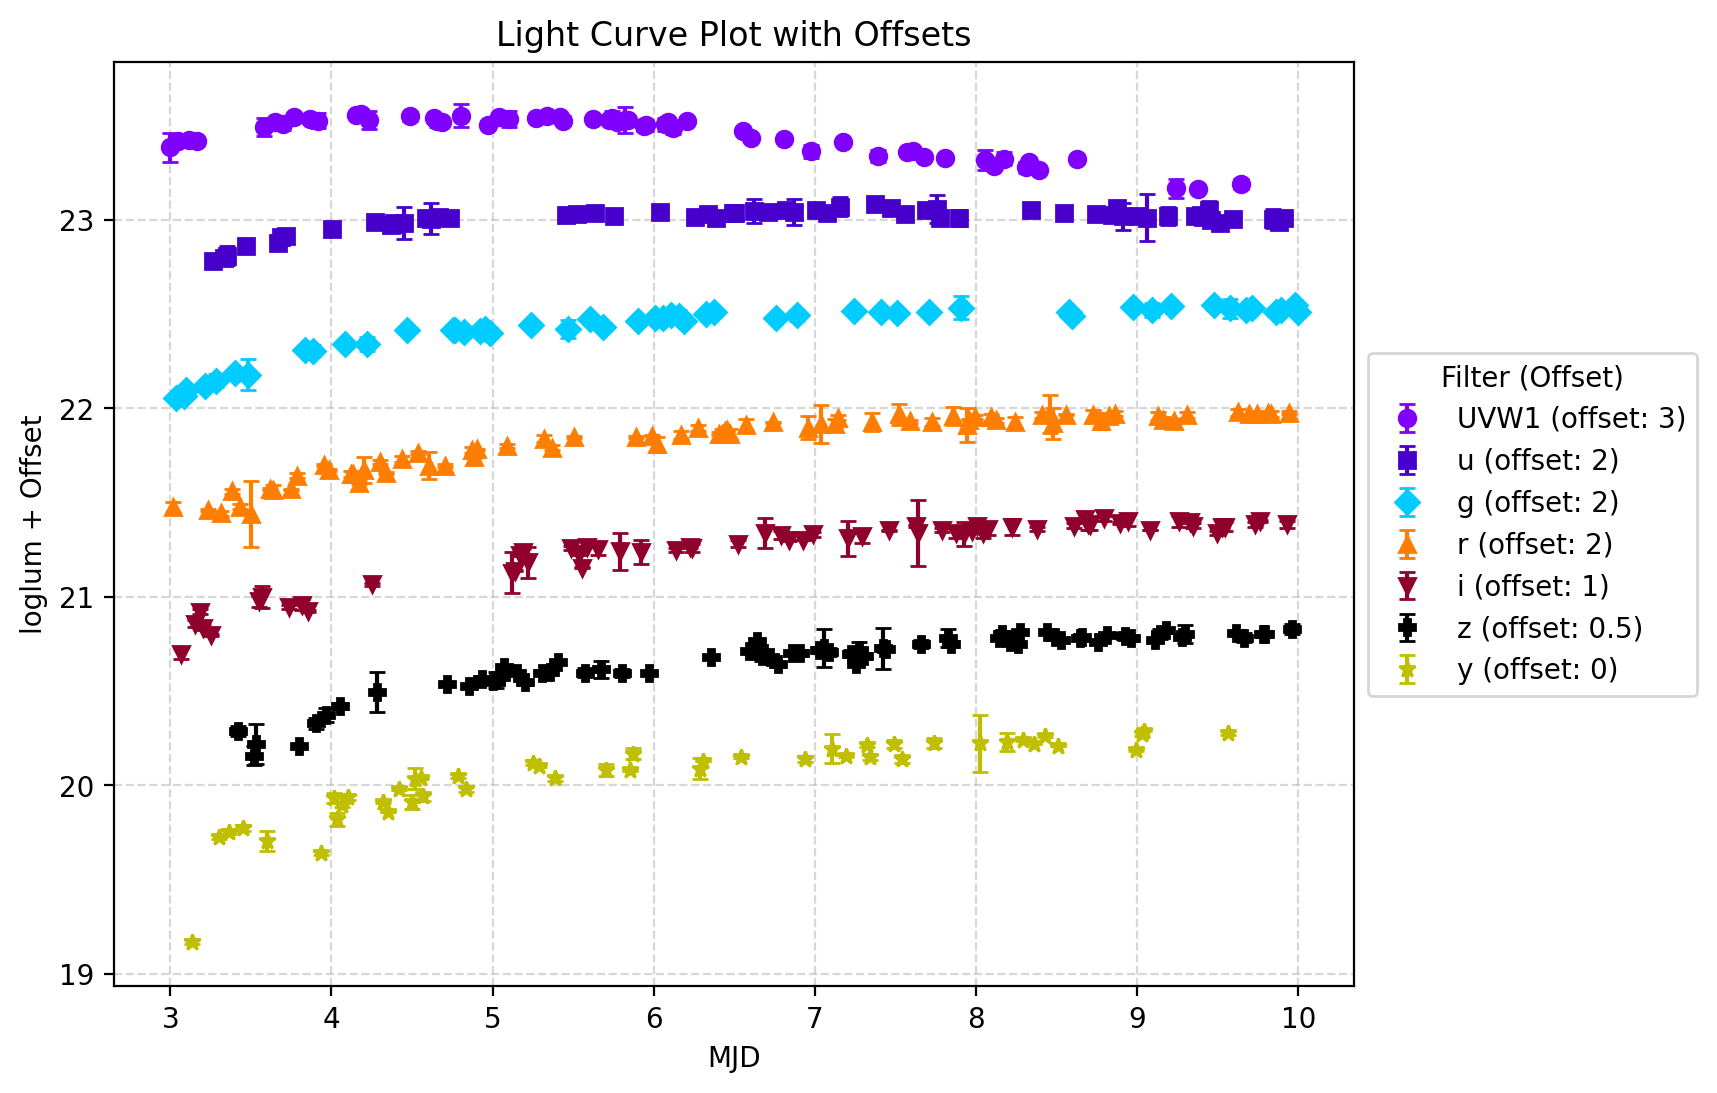

In [6]:
# --- define cumulative filter sets (z → UV) ---

all_filters = ["z", "y", "i", "r", "g", "u", "uvw1"]  # from red to UV
mjd_array = np.linspace(3, 13, 600)


filter_combinations = [all_filters[:i+1] for i in range(len(all_filters))]

max_days = 10
time_spans = np.arange(1, max_days + 1)  # [1, 2, ..., 10]

model_parameters = [1.2, 2., 4.0, 2.5]

# --- setup light curve builder ---
builder = ut.LCBuilder(
    model_name="sc4",
    model_parameters=model_parameters,
    model_units=[1,1,1,1],
    seed=42
)

lc = builder.build_sim_lc(
    mjd_array=mjd_array,
    filters_list=all_filters,  # full set
    redshift=0.00526,
    dlum_factor=1e-1/2,
    dm=31.1,
    dL=19.,
    dLerr=2.9
)
light_curve_plot(lc.where(MJD_max=10), offset = .5, ycol="loglum")

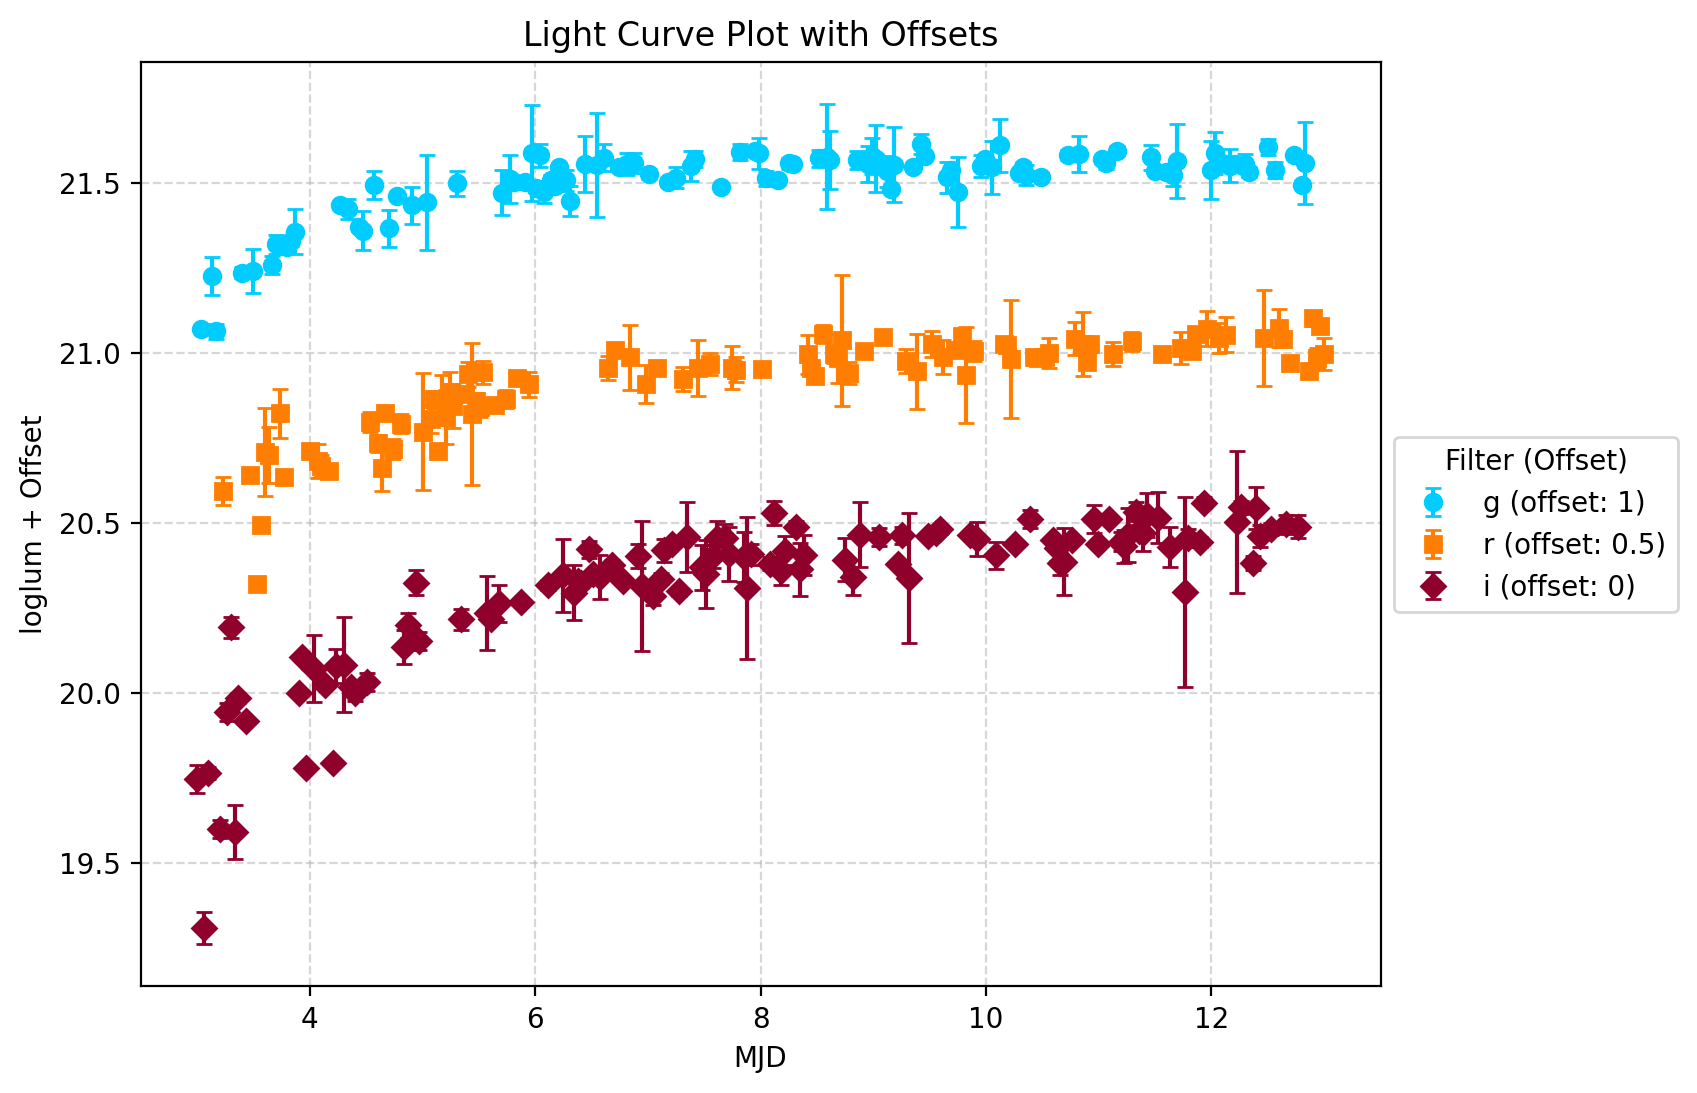

In [68]:
builder = ut.LCBuilder(model_name="sc4",
                       model_parameters=[1.26491106, 2., 4.03506331, 2.5],
                       model_units=[1,1,1,1],
                       seed=42)

lc = builder.build_sim_lc(mjd_array=np.linspace(3, 13, 300),
                          filters_list=["g", "r", "i"],
                          redshift=0.00526,
                          dlum_factor = 1e-1,
                          dm=31.1,
                          dL=19.,
                          dLerr=2.9)
light_curve_plot(lc, offset = .5, ycol="loglum")

## importing real light curve

In [69]:
# lc_dir = os.path.join("../data/2022acko", "2022acko_total.dat")
# lc = load_lc(lc_dir=lc_dir)
# lc.calcAbsMag()
# lc.calcLum()
# light_curve_plot(lc, ycol="lum")


## Setting torch objects

In [ ]:
dd

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torchenizer = tp.Torchenizer(lc, ycol="loglum", device=device)

X_DATA, filters_mask, ufilters = torchenizer.get_xdata(max_phase=8, t0_offset=3)

Using device: cuda


# Setting Model
and training

In [71]:
nn_model_name = "bnn_pilca.pth"
model_save_dir = os.path.join(ut.storage_parent_path, "models", nn_model_name)

nn_model = tp.MultiFilterBNN(x_data=X_DATA,
                            filters_mask=filters_mask,
                            param_dim=4,
                            hidden_dim=32).to(device)

criterion = tp.ModifiedSC4Loss(ufilters=ufilters,
                               z=lc.meta["redshift"],
                               mode="mean_param",
                               min_t0=torch.min(X_DATA[:,0])-1e-5)
lr=1e-3
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=500, gamma=0.5)

trainer = tp.Trainer(model=nn_model,
                    criterion=criterion,
                    epochs=2000,
                    n_samples_loss=30,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    verbose_step=100,
                    save_dir=model_save_dir)

history = trainer.train()

--- Step 0 ---
Shock velocity (v_s):     2.3548
Envelope mass (M_env):    4.4288
Density factor (f_rho_M): 4.4288
Radius (R):               3.9097
Explosion time (t_exp):   1.8679
Loss:                     0.354084
----------------------------------------
--- Step 100 ---
Shock velocity (v_s):     1.6206
Envelope mass (M_env):    1.8620
Density factor (f_rho_M): 1.8620
Radius (R):               2.4508
Explosion time (t_exp):   2.5244
Loss:                     0.006151
----------------------------------------
--- Step 200 ---
Shock velocity (v_s):     1.4618
Envelope mass (M_env):    1.7758
Density factor (f_rho_M): 1.7758
Radius (R):               2.9012
Explosion time (t_exp):   2.4130
Loss:                     0.005048
----------------------------------------
--- Step 300 ---
Shock velocity (v_s):     1.4225
Envelope mass (M_env):    1.7009
Density factor (f_rho_M): 1.7009
Radius (R):               3.2527
Explosion time (t_exp):   2.3681
Loss:                     0.005235
-----------

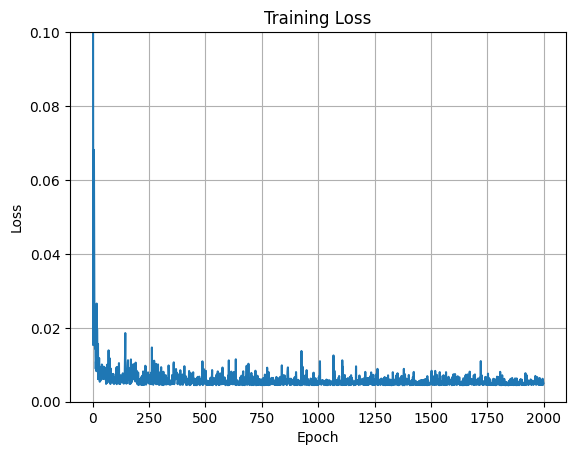

In [74]:
plt.plot(history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.ylim(0,0.1)
plt.show()
